In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.train import Checkpoint
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LeakyReLU, ReLU, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Add, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = 10
train_images = train_images/255
test_images = test_images/255
train_labels = tf.keras.utils.to_categorical(train_labels,num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels,num_classes)

In [ ]:
class ResNetv1:
    def __init__(self, inputdims, outputdims, lr=0.001, regconst=0.00001, maxpool=False, epochs=125, 
                lrschedule=lr_schedule, batchsize=64):
        self.inputdims = inputdims
        self.outputdims = outputdims
        self.lr = lr
        self.regconst = regconst
        self.filtermap = 32
        self.lrschedule = lrschedule
        self.optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.epochs = epochs
        self.batchsize=batchsize
        self.model = self.buildNet(maxpool)
        self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
        )
        self.model.summary()

    def convBlock(self, x, filters=1, k=3):
        x = Conv2D(filters*self.filtermap, (k, k), padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(self.regconst))(x)
        x = ReLU()(x)
        x = BatchNormalization()(x)

        return x

    def resBlock(self, i, filters=1):
        x = self.convBlock(i, filters)
        x = self.convBlock(i, filters)
        x = Add()([x, i])
        x = ReLU()(x)
        x = BatchNormalization()(x)

        return x

    def poolBlock(self, x, maxpool=False, k=2):
        return AveragePooling2D((k, k))(x) if not maxpool else MaxPooling2D((k, k))(x)

    def buildNet(self, maxpool):
        image = Input(shape=(self.inputdims))

        x = self.convBlock(image)
        for i in range(2):
            x = self.resBlock(x)

        x = self.convBlock(x, 2)
        x = self.poolBlock(x, maxpool)
        for i in range(2):
            x = self.resBlock(x, 2)

        x = self.convBlock(x, 4)
        x = self.poolBlock(x, maxpool)
        for i in range(2):
            x = self.resBlock(x, 4)

        x = self.convBlock(x, 2)
        x = self.poolBlock(x, maxpool)

        x = Flatten()(x)
        x = Dropout(0.3)(x)
        probs = Dense(self.outputdims, activation='softmax')(x)

        model = Model(image, probs)
        model.compile(optimizer=self.optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])

        return model

    def fit(self, xtrain, ytrain, xtest, ytest):
        self.datagen.fit(xtrain)

        history = self.model.fit(self.datagen.flow(xtrain, ytrain, batch_size=self.batchsize),
                                    steps_per_epoch=train_images.shape[0] // self.batchsize, 
                                    epochs=self.epochs,
                                    verbose=1, validation_data=(xtest, ytest), 
                                    callbacks=[LearningRateScheduler(self.lrschedule)])
        
        return history


In [ ]:
resnetv1 = ResNetv1(train_images.shape[1:], num_classes, maxpool=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         re_lu[0][0]                      
______________________________________________________________________________________________

In [ ]:
resnetv1.fit(train_images, train_labels, test_images, test_labels)

Epoch 1/125
781/781 [==============================] - 26s 33ms/step - loss: 1.7341 - accuracy: 0.4423 - val_loss: 1.5806 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 2/125
781/781 [==============================] - 26s 33ms/step - loss: 1.1956 - accuracy: 0.6016 - val_loss: 1.1651 - val_accuracy: 0.6290 - lr: 0.0010
Epoch 3/125
781/781 [==============================] - 25s 33ms/step - loss: 0.9303 - accuracy: 0.6784 - val_loss: 0.9217 - val_accuracy: 0.6983 - lr: 0.0010
Epoch 4/125
781/781 [==============================] - 26s 33ms/step - loss: 0.7902 - accuracy: 0.7295 - val_loss: 0.8440 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 5/125
781/781 [==============================] - 25s 33ms/step - loss: 0.7132 - accuracy: 0.7579 - val_loss: 0.7576 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 6/125
781/781 [==============================] - 25s 32ms/step - loss: 0.6553 - accuracy: 0.7780 - val_loss: 0.7379 - val_accuracy: 0.7573 - lr: 0.0010
Epoch 7/125
781/781 [==============================]

In [ ]:
test_loss, test_acc = resnetv1.model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.5083 - accuracy: 0.9111


NameError: ignored

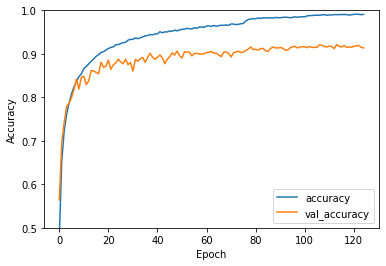

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')



In [ ]:
kaggle datasets download -d paultimothymooney/chest-xray-pneumonia